In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
from implicit.datasets.lastfm import get_lastfm
import h5py
from implicit.nearest_neighbours import bm25_weight
import scipy
import matplotlib.pyplot as plt
from scipy import stats

from sklearn.model_selection import KFold
from implicit.evaluation import ndcg_at_k
from implicit.evaluation import train_test_split
from implicit.als import AlternatingLeastSquares

# LastFM Dataset

In [2]:
def get_users_by_usage(ratings_df):

    labels = list(range(1, 8))
    popularity_cut = pd.qcut(ratings_df.groupby('user_id').artist_id.nunique(), 7)
    popularity_cut = popularity_cut.cat.rename_categories(labels)
    popularity_cut = pd.DataFrame(popularity_cut)
    popularity_cut = popularity_cut.reset_index(drop=False)
    popularity_cut.columns = ['user_id', 'usage']

    popularity_cut_counts = pd.DataFrame(popularity_cut.groupby('usage').count())
    popularity_cut_counts = popularity_cut_counts.reset_index(drop=False)
    popularity_cut_counts['percentage'] = popularity_cut_counts.user_id / popularity_cut_counts.user_id.sum()

    return popularity_cut, popularity_cut_counts

In [3]:
def get_divided_test_fold(ratings_df, test_index, sampling_rate=.2):
    test_fold_df = ratings_df[ratings_df.user_id.isin(test_index)].copy()
    test_df = test_fold_df.groupby('user_id').sample(frac=.2)
    test_fold_df.loc[test_fold_df.user_id.isin(test_df.user_id), 'plays'] = 0

    return test_fold_df, test_df

In [4]:
def get_age_bins():
    age_bins = {}
    age_bins[1] = '1-17'
    age_bins[18] = '18-24'
    age_bins[25] = '25-34'
    age_bins[35] = '35-44'
    age_bins[45] = '45-49'
    age_bins[50] = '50-55'
    age_bins[56] = '56+',
    age_bins['NaN'] = 'NaN'

    age_labels = list(age_bins.values())

    return age_bins, age_labels

In [5]:
def get_metric_dict(users, column, values=None):
    metric_dict = {}
    if not values:
        values = users[column].unique()
    for g in values:
        metric_dict[g] = []
    return metric_dict

# Preparation

In [125]:
cols = ['user_id', 'artist_id', 'artist_name', 'plays']
data_artists = pd.read_csv("lastfm-dataset-360K/usersha1-artmbid-artname-plays.tsv", sep="\t", names=cols, header=None)

cols = ['user_id', 'gender', 'age', 'country', 'signup']
data_users = pd.read_csv("lastfm-dataset-360K/usersha1-profile.tsv", sep="\t", names=cols, header=None)

bins = [0, 18, 25, 35, 45, 50, 56, np.inf]
names = ['1', '18','25', '35', '45', '50','55']
data_users['AgeRange'] = pd.cut(data_users['age'], bins, labels=names)
data_users['AgeRange'] = pd.to_numeric(data_users['AgeRange'])

df = pd.merge(data_artists, data_users, on='user_id')

artists, users, artist_user_plays = get_lastfm()
# artist_user_plays = bm25_weight(artist_user_plays, K1=100, B=0.8)

# user_plays = artist_user_plays.T.tocsr()
user_plays = artist_user_plays.T

# CV

In [126]:
users_df = pd.DataFrame({'user': users}).reset_index()
users_df.rename(columns={"index": "user_id"}, inplace=True)
c = user_plays.tocoo()
t_df = pd.DataFrame({'user_id': c.row, 'artist_id': c.col, 'plays': c.data})
t_df = pd.merge(t_df, users_df, on='user_id')
# t_df = t_df.drop(['index'], axis=1)

artists_df = pd.DataFrame({'artist': artists}).reset_index()
artists_df.rename(columns={"index": "artist_id"}, inplace=True)
t_df = pd.merge(t_df, artists_df, on='artist_id')
# t_df = t_df.drop(['index'], axis=1)


counts = t_df['user_id'].value_counts()
t_df_40 = t_df[~t_df['user_id'].isin(counts[counts < 41].index)]
# t_df_40.reset_index()
# counts_5000 = counts.sample(n = 5000, random_state = 12345)
# t_df_5000 = t_df_40[t_df_40['users'].isin(counts_5000.index)]

list1 = t_df_40['user_id'].tolist()
list2 = t_df_40['artist_id'].tolist()
list3 = t_df_40['plays'].tolist()
# list3 = t_df_40['index'].tolist()

c.row = np.array(list1)
c.col = np.array(list2)
c.data = np.array(list3)

new_matrix = scipy.sparse.csr_matrix(c)
user_plays = new_matrix

In [127]:
# t_df_40 = pd.merge(t_df_40, df, left_on='user', right_on='user_id')
popularity_cut, popularity_cut_counts = get_users_by_usage(df)
age_bins, age_labels = get_age_bins()

In [128]:
user_plays.shape

(358868, 292385)

In [129]:
ndcg_dict_age = get_metric_dict(data_users, 'AgeRange')
ndcg_dict_gender = get_metric_dict(data_users, 'gender')
ndcg_dict_usage = get_metric_dict(data_users, '', values=range(1, 8))

In [130]:
ndcg_dicts = {}
ndcg_dicts['AgeRange'] = get_metric_dict(data_users, 'AgeRange')
ndcg_dicts['gender'] = get_metric_dict(data_users, 'gender')
ndcg_dicts['usage'] = get_metric_dict(data_users, '', values=range(1, 8))

In [131]:
# divide ratings into 5 CV, still question about test data - see paper
# 0th column is 0, since user ids start with 1

kf = KFold(n_splits=5, random_state=12345, shuffle=True)

for i, (train_index, test_index) in enumerate(kf.split(user_plays)):
    print(f"Fold {i}:")
    print(f"  Train: index={train_index.shape}")

    # train data is divided into two parts
    # in train_index, full user data is used for training
    # in test_index, 80% of user data is used for training and the rest 20% is used for testing
    test_train_df, test_test_df = get_divided_test_fold(t_df_40, test_index)
    train_data = user_plays.copy()
    # blend out the 20% of test users data for testing
    # test data contains data used for training + 20% blended in train data
    train_data[test_test_df.user_id, test_test_df.artist_id] = 0

    model = AlternatingLeastSquares(factors=50, regularization=0.01)
    model.fit(train_data)
    print(f'Model trained, starting evaluation...')
    # test_test_df = test_test_df.merge(t_df_40, how='left', left_on='user', right_on='user')
    test_test_df = test_test_df.merge(df, how='left', left_on='user', right_on='user_id')
    test_test_df = test_test_df.merge(popularity_cut, how='left', left_on='user', right_on='user_id')
    test_test_df = test_test_df.dropna()
    test_test_df = test_test_df.sample(n = 5000, random_state = 12345)

    print(f"  Test:  index={test_test_df.shape}")

    for col, ndcg_dict in ndcg_dicts.items():
        print(f'Starting evaluation by {col} groups...')
        for a in test_test_df[col].unique():
            test_data = user_plays[test_test_df[test_test_df[col] == a].user_id_x.unique()]
            ndcg_dict[a].append(ndcg_at_k(model, train_data, test_data, K=1000))
        print(f'Evaluation by {col} finished...')

Fold 0:
  Train: index=(287094,)


  0%|          | 0/15 [00:00<?, ?it/s]

Model trained, starting evaluation...
  Test:  index=(5000, 16)
Starting evaluation by AgeRange groups...


  0%|          | 0/297 [00:00<?, ?it/s]

  0%|          | 0/2485 [00:00<?, ?it/s]

  0%|          | 0/1210 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

  0%|          | 0/583 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/34 [00:00<?, ?it/s]

Evaluation by AgeRange finished...
Starting evaluation by gender groups...


  0%|          | 0/3550 [00:00<?, ?it/s]

  0%|          | 0/1192 [00:00<?, ?it/s]

Evaluation by gender finished...
Starting evaluation by usage groups...


  0%|          | 0/790 [00:00<?, ?it/s]

  0%|          | 0/440 [00:00<?, ?it/s]

  0%|          | 0/503 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/690 [00:00<?, ?it/s]

  0%|          | 0/1079 [00:00<?, ?it/s]

  0%|          | 0/171 [00:00<?, ?it/s]

Evaluation by usage finished...
Fold 1:
  Train: index=(287094,)


  0%|          | 0/15 [00:00<?, ?it/s]

Model trained, starting evaluation...
  Test:  index=(5000, 16)
Starting evaluation by AgeRange groups...


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/2371 [00:00<?, ?it/s]

  0%|          | 0/1358 [00:00<?, ?it/s]

  0%|          | 0/275 [00:00<?, ?it/s]

  0%|          | 0/560 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Evaluation by AgeRange finished...
Starting evaluation by gender groups...


  0%|          | 0/1191 [00:00<?, ?it/s]

  0%|          | 0/3540 [00:00<?, ?it/s]

Evaluation by gender finished...
Starting evaluation by usage groups...


  0%|          | 0/781 [00:00<?, ?it/s]

  0%|          | 0/1084 [00:00<?, ?it/s]

  0%|          | 0/1066 [00:00<?, ?it/s]

  0%|          | 0/728 [00:00<?, ?it/s]

  0%|          | 0/522 [00:00<?, ?it/s]

  0%|          | 0/379 [00:00<?, ?it/s]

  0%|          | 0/171 [00:00<?, ?it/s]

Evaluation by usage finished...
Fold 2:
  Train: index=(287094,)


  0%|          | 0/15 [00:00<?, ?it/s]

Model trained, starting evaluation...
  Test:  index=(5000, 16)
Starting evaluation by AgeRange groups...


  0%|          | 0/2431 [00:00<?, ?it/s]

  0%|          | 0/1264 [00:00<?, ?it/s]

  0%|          | 0/605 [00:00<?, ?it/s]

  0%|          | 0/297 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Evaluation by AgeRange finished...
Starting evaluation by gender groups...


  0%|          | 0/3557 [00:00<?, ?it/s]

  0%|          | 0/1173 [00:00<?, ?it/s]

Evaluation by gender finished...
Starting evaluation by usage groups...


  0%|          | 0/1028 [00:00<?, ?it/s]

  0%|          | 0/1057 [00:00<?, ?it/s]

  0%|          | 0/190 [00:00<?, ?it/s]

  0%|          | 0/463 [00:00<?, ?it/s]

  0%|          | 0/770 [00:00<?, ?it/s]

  0%|          | 0/776 [00:00<?, ?it/s]

  0%|          | 0/446 [00:00<?, ?it/s]

Evaluation by usage finished...
Fold 3:
  Train: index=(287095,)


  0%|          | 0/15 [00:00<?, ?it/s]

Model trained, starting evaluation...
  Test:  index=(5000, 16)
Starting evaluation by AgeRange groups...


  0%|          | 0/2414 [00:00<?, ?it/s]

  0%|          | 0/327 [00:00<?, ?it/s]

  0%|          | 0/1226 [00:00<?, ?it/s]

  0%|          | 0/598 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/37 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

Evaluation by AgeRange finished...
Starting evaluation by gender groups...


  0%|          | 0/3553 [00:00<?, ?it/s]

  0%|          | 0/1166 [00:00<?, ?it/s]

Evaluation by gender finished...
Starting evaluation by usage groups...


  0%|          | 0/749 [00:00<?, ?it/s]

  0%|          | 0/1039 [00:00<?, ?it/s]

  0%|          | 0/191 [00:00<?, ?it/s]

  0%|          | 0/427 [00:00<?, ?it/s]

  0%|          | 0/1025 [00:00<?, ?it/s]

  0%|          | 0/798 [00:00<?, ?it/s]

  0%|          | 0/490 [00:00<?, ?it/s]

Evaluation by usage finished...
Fold 4:
  Train: index=(287095,)


  0%|          | 0/15 [00:00<?, ?it/s]

Model trained, starting evaluation...
  Test:  index=(5000, 16)
Starting evaluation by AgeRange groups...


  0%|          | 0/593 [00:00<?, ?it/s]

  0%|          | 0/2364 [00:00<?, ?it/s]

  0%|          | 0/1311 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

  0%|          | 0/289 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

Evaluation by AgeRange finished...
Starting evaluation by gender groups...


  0%|          | 0/1164 [00:00<?, ?it/s]

  0%|          | 0/3536 [00:00<?, ?it/s]

Evaluation by gender finished...
Starting evaluation by usage groups...


  0%|          | 0/414 [00:00<?, ?it/s]

  0%|          | 0/1047 [00:00<?, ?it/s]

  0%|          | 0/1040 [00:00<?, ?it/s]

  0%|          | 0/209 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/740 [00:00<?, ?it/s]

  0%|          | 0/468 [00:00<?, ?it/s]

Evaluation by usage finished...


## Kruskal-Wallis Significance tests

In [132]:
from math import isnan

clean_ndcg = {}
clean_ndcg['age'] = {k: ndcg_dicts['AgeRange'][k] for k in ndcg_dicts['AgeRange'] if not isnan(k)}
clean_ndcg['gender'] = {'f': ndcg_dicts['gender']['f'], 'm': ndcg_dicts['gender']['m']}
clean_ndcg['usage'] = {}
clean_ndcg['usage'].update(ndcg_dicts['usage'])
clean_ndcg

{'age': {18.0: [0.13855069745776682,
   0.13955627478709487,
   0.13857708712795616,
   0.13525878531985222,
   0.1395596876654208],
  25.0: [0.13197533059914232,
   0.13323423777207552,
   0.13690052712626008,
   0.13706242385130502,
   0.13307056573967277],
  1.0: [0.14079199664333392,
   0.13963921467237497,
   0.13186194232168338,
   0.13772116980028384,
   0.13089373073138058],
  45.0: [0.11688540535191132,
   0.11622487500161152,
   0.11525095024375855,
   0.10182216405688314,
   0.1286138820016177],
  50.0: [0.14422304311083967,
   0.09522098769536436,
   0.10408061800656912,
   0.11349359668016269,
   0.07617830013792551],
  55.0: [0.09962243931450149,
   0.10967027556080587,
   0.11090125223522877,
   0.08612369681883443,
   0.07864704609425868],
  35.0: [0.12402029593410455,
   0.11720455153042994,
   0.12800972092264906,
   0.12659561005698405,
   0.12604771487759225]},
 'gender': {'f': [0.14543519566653595,
   0.14075216931479956,
   0.1384772220266845,
   0.140424796171730

In [133]:
ndcg_dicts['usage'].keys()

dict_keys([1, 2, 3, 4, 5, 6, 7])

In [134]:
def get_kruskal(clean_ndcg, key_col):
    gender_list = clean_ndcg[key_col].values()
    return stats.kruskal(*gender_list)

In [135]:
for c, ndcg_dict in clean_ndcg.items():
    kruskal_val = get_kruskal(clean_ndcg, c)
    print(f'Kruscal-Wallis test for {c}: {kruskal_val}')

Kruscal-Wallis test for age: KruskalResult(statistic=23.596190476190486, pvalue=0.0006195216267634696)
Kruscal-Wallis test for gender: KruskalResult(statistic=6.818181818181813, pvalue=0.009023438818080334)
Kruscal-Wallis test for usage: KruskalResult(statistic=32.076190476190476, pvalue=1.5777903335170258e-05)


## By age and gender

In [136]:
def get_df_from_eval_dict(ndcg_dicts, key_col, eval_col='ndcg'):
    df_ndcg = pd.DataFrame(ndcg_dicts[key_col])
    df_ndcg = df_ndcg.melt()
    df_ndcg.columns = [key_col, eval_col]
    return df_ndcg

In [137]:
df_ndcg_age = get_df_from_eval_dict(clean_ndcg, 'age')
df_ndcg_gender = get_df_from_eval_dict(clean_ndcg, 'gender')

<AxesSubplot: title={'center': 'NDCG distribution for users grouped by gender'}, xlabel='gender', ylabel='ndcg'>

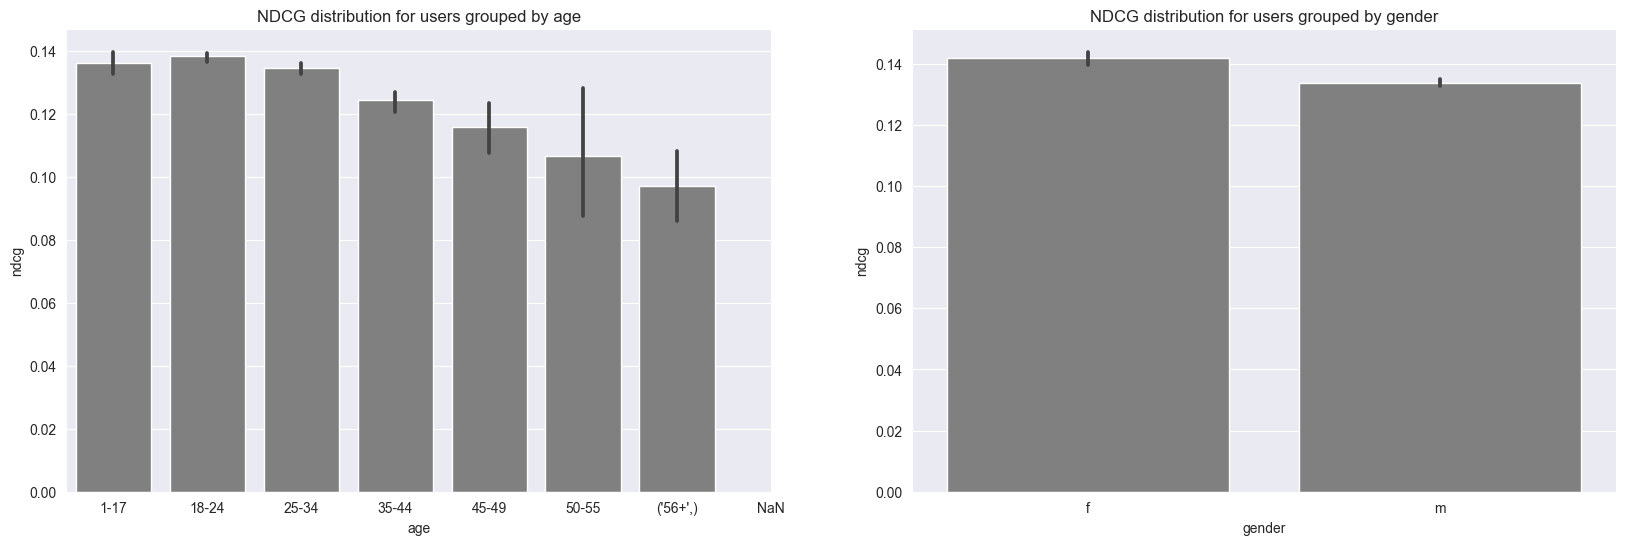

In [138]:
_, ax = plt.subplots(1, 2, figsize=(20, 6))
sns.despine()

ax[0].set_title('NDCG distribution for users grouped by age')
sns.barplot(data=df_ndcg_age, x='age', y='ndcg', color='grey', ax=ax[0])
ax[0].set_xticks(list(range(0, len(age_bins))), labels=age_labels)

ax[1].set_title('NDCG distribution for users grouped by gender')
sns.barplot(data=df_ndcg_gender, x='gender', y='ndcg', color='grey', ax=ax[1])

## By usage

<AxesSubplot: title={'center': 'NDCG distribution for users grouped by usage'}, xlabel='usage', ylabel='ndcg'>

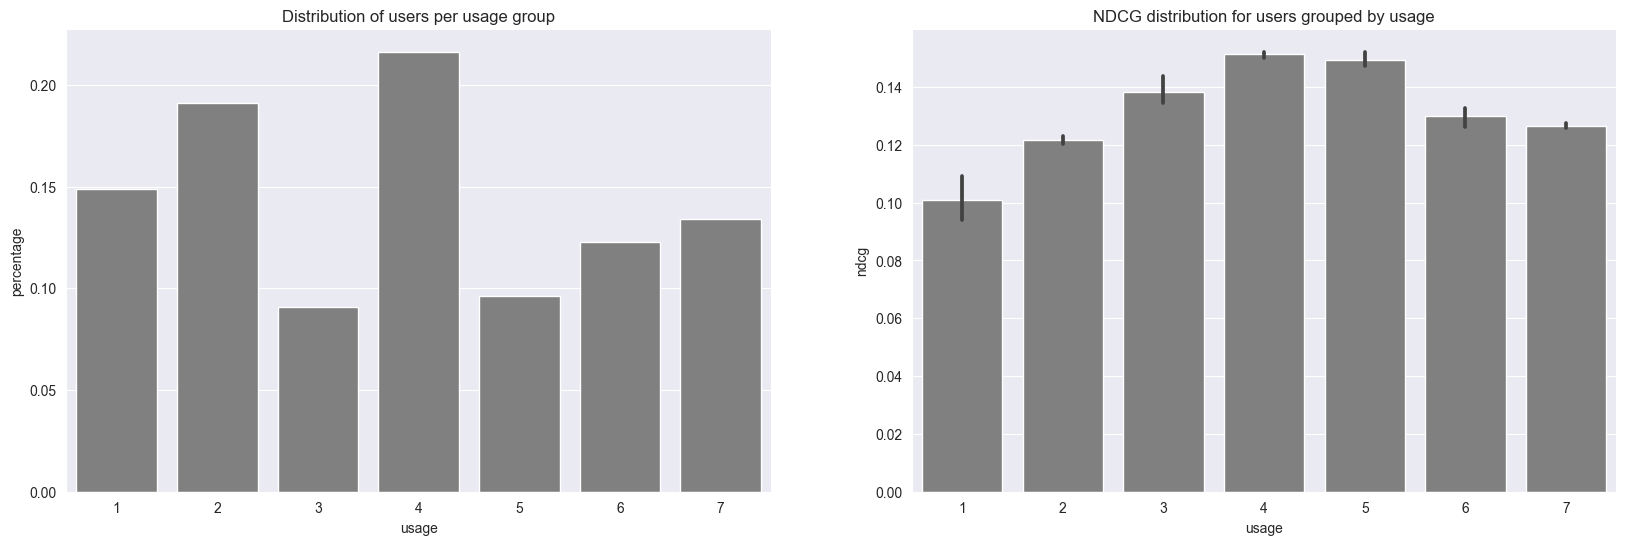

In [139]:
df_ndcg_usage = get_df_from_eval_dict(ndcg_dicts, 'usage')

_, ax = plt.subplots(1, 2, figsize=(20, 6))
sns.despine()

ax[0].set_title('Distribution of users per usage group')
sns.barplot(data=popularity_cut_counts, x='usage', y='percentage', color='grey', ax=ax[0], )

ax[1].set_title('NDCG distribution for users grouped by usage')
sns.barplot(data=df_ndcg_usage, x='usage', y='ndcg', color='grey', ax=ax[1])

## User distributions

<AxesSubplot: title={'center': 'Distribution of users per gender'}, xlabel='gender', ylabel='count'>

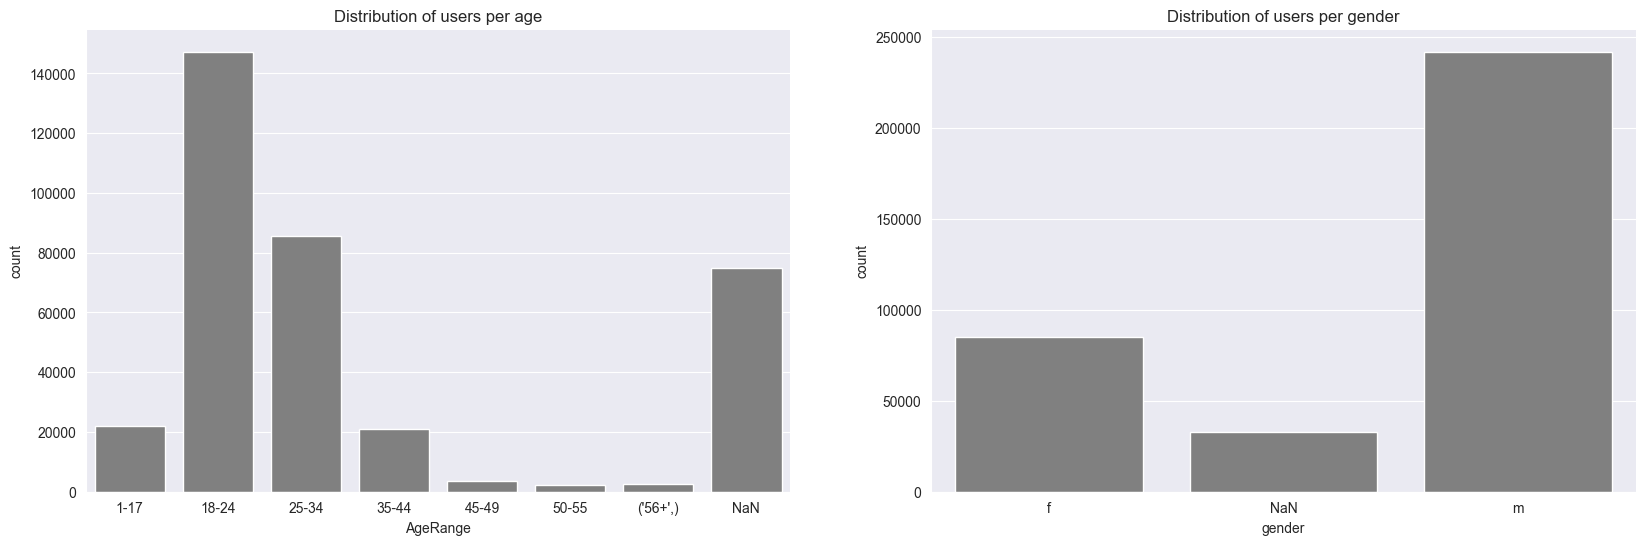

In [141]:
plot_data = data_users.copy()
bins = [0, 18, 25, 35, 45, 50, 56, np.inf, 'NaN']
names = ['1', '18','25', '35', '45', '50','55+', 'NaN']

plot_data['AgeRange'] = pd.cut(plot_data['age'], bins, labels=names)
plot_data["AgeRange"] = plot_data["AgeRange"].fillna('NaN')
plot_data["gender"] = plot_data["gender"].fillna('NaN')

from matplotlib import pyplot as plt

_, ax = plt.subplots(1, 2, figsize=(20, 6))
sns.despine()

ax[0].set_title('Distribution of users per age')
sns.countplot(data=plot_data, x='AgeRange', color='grey', ax=ax[0])
ax[0].set_xticks(list(range(0, len(age_bins))), labels=age_labels)

ax[1].set_title('Distribution of users per gender')
sns.countplot(data=plot_data, x='gender', color='grey', ax=ax[1])

In [155]:
userid = 0
ids, scores = model.recommend(userid, user_plays[userid], N=10, filter_already_liked_items=False)

In [156]:
# Use pandas to display the output in a table, pandas isn't a dependency of implicit otherwise
import numpy as np
import pandas as pd
pd.DataFrame({
    "artist": artists[ids],
    "score": scores,
    "already_liked": np.in1d(ids, user_plays[userid].indices)
})

,artist,score,already_liked
0,oliver shanti & friends,0.0,False
1,mohamed lamine,0.0,False
2,mala rodriguez,0.0,False
3,kanye west,0.0,False
4,fatboy slim,0.0,False
5,cours de la somme,0.0,False
6,amy winehouse,0.0,False
7,80lİ yillarin tÜrkÇe sÖzlÜ aŞk Şarkilari,0.0,False
8,58725ab=>,0.0,False
9,2,0.0,False


In [157]:
# get related items for the beatles (itemid = 25512)
ids, scores= model.similar_items(0)

# display the results using pandas for nicer formatting
pd.DataFrame({"artist": artists[ids], "score": scores})

,artist,score
0,oliver shanti & friends,0.0
1,mohamed lamine,0.0
2,mala rodriguez,0.0
3,kanye west,0.0
4,fatboy slim,0.0
5,cours de la somme,0.0
6,amy winehouse,0.0
7,80lİ yillarin tÜrkÇe sÖzlÜ aŞk Şarkilari,0.0
8,58725ab=>,0.0
9,2,0.0


In [142]:
# Make 1000 recommendations for each user in the dataset
userids = np.arange(len(users))
ids, scores = model.recommend(userids, user_plays[userids], N=10)
ids, ids.shape

KeyboardInterrupt: 

In [ ]:
rec = pd.DataFrame({"user": users, "artist": artists[ids], "score": scores})

list1 = rec['users'].tolist()
list2 = rec['artists'].tolist()
list3 = rec['rel'].tolist()

c.row = np.array(list1)
c.col = np.array(list2)
c.data = np.array(list3)

import scipy
new_matrix = scipy.sparse.csr_matrix(c)
rec_res = new_matrix

In [ ]:
rec_users = data_users[data_users['user-mboxsha1'].isin(users)]
rec_users

In [ ]:
df_id_users = pd.DataFrame(users, columns=['users'])
df_id_users[~df_id_users["users"].isin(rec_users['user-mboxsha1'])]

In [ ]:
users_clean = np.delete(users, [312192, 358867])
scores_clean = np.delete(scores, [312192, 358867], axis=0)
ids_clean = np.delete(ids, [312192, 358867], axis=0)
scores_clean.shape, users_clean.shape, ids_clean.shape